In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# View column name/type for measurement class
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# View column name/type for station class
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Save references to each table
Measure=Base.classes.measurement
Station=Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
import datetime as dt
newest = session.query(Measure.date).order_by(Measure.date.desc()).first()
newest = newest[0]
newest

'2017-08-23'

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Calculate the date one year from the newest date in dataset.
yr_prior = dt.date(2017, 8, 23) - dt.timedelta(days=365)
yr_prior

datetime.date(2016, 8, 23)

In [13]:
# Perform a query to retrieve the data and precipitation scores
# Find all of the dates greater than `2016-08-23`
yr_prior_dt = dt.date(2016, 8, 23)
qdata = session.query(Measure.date, Measure.station, Measure.prcp, Measure.tobs).filter(Measure.date > yr_prior_dt).all()

In [24]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
qdata_df = pd.DataFrame(qdata, columns=['date', 'station', 'prcp', 'tobs'])

# Sort the dataframe by date
qdata_df = qdata_df.sort_values("date")

# Filter out all rows with a prcp value of "none".
qdata_df = qdata_df.dropna(subset=['prcp'])

# Reset the index
qdata_df = qdata_df.reset_index(drop=True)

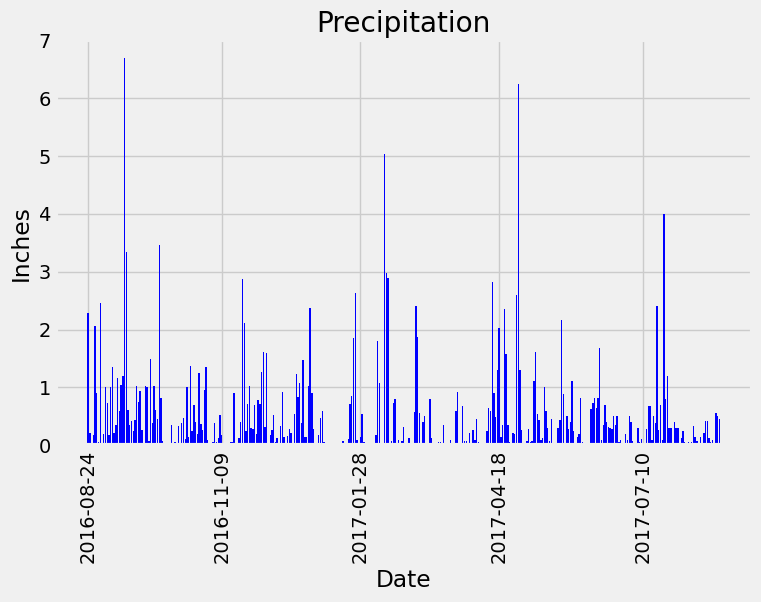

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
# Extract the date and prcp columns
dates = qdata_df['date']
prcp = qdata_df['prcp']

# Set the size of the figure
plt.figure(figsize=(8, 5))

# Plot the bar graph
plt.bar(dates, prcp, color='b', linewidth=3, align="center")

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation')

# Specify the axis values and labels
x_ticks = ['2016-08-24', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
plt.xticks(x_ticks, rotation="vertical")
plt.ylim(0, 7)

# Display the plot.
plt.show()

In [16]:
# SEE README FILE FOR NOTES ON THIS CELL.
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = qdata_df['prcp'].describe().to_frame().rename(columns={'prcp': 'precipitation'})
summary_stats.head(20)


,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
stn_count = session.query(Station).distinct().count()
print(stn_count)

9


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stn_activity = session.query(Measure.station, func.count(Measure.station)).\
    group_by(Measure.station).\
    order_by(func.count(Measure.station).desc()).all()

# Print the stations and their counts
for station, count in stn_activity:
    print({station}, {count})

{'USC00519281'} {2772}
{'USC00519397'} {2724}
{'USC00513117'} {2709}
{'USC00519523'} {2669}
{'USC00516128'} {2612}
{'USC00514830'} {2202}
{'USC00511918'} {1979}
{'USC00517948'} {1372}
{'USC00518838'} {511}


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = [func.min(Measure.tobs),
         func.max(Measure.tobs),
         func.avg(Measure.tobs)]
target_temps = session.query(*temps).filter(Measure.station == "USC00519281").all()
target_temps

[(54.0, 85.0, 71.66378066378067)]

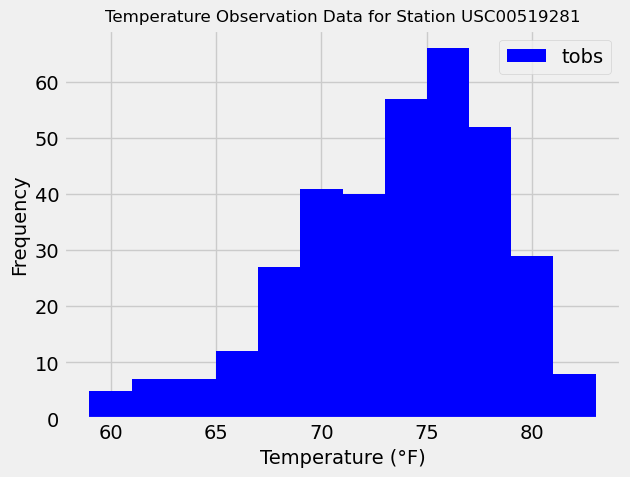

In [30]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stn_qdata = session.query(Measure.tobs).filter(Measure.station == "USC00519281").filter(Measure.date > yr_prior_dt).all()

# Extract the temperatures from the query results
stn_temps = [result[0] for result in stn_qdata]

# Plot the results as a histogram
plt.hist(stn_temps, bins=12, alpha=1, color='b')
plt.title("Temperature Observation Data for Station USC00519281", fontsize=12)
plt.xlabel("Temperature (°F)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(['tobs'], loc='upper right')
plt.show()



# Close Session

In [31]:
# Close Session
session.close()